In [41]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import torch
import torch.nn as nn

sns.set()
plt.rcParams['font.sans-serif'] = ['SimHei']	# 显示中文
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

In [42]:
def parse(x):
    return datetime.datetime.strptime(x, '%Y %m %d %H')

In [43]:
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', 
                        parse_dates=[['year', 'month', 'day', 'hour']], 
                        index_col=0, 
                        date_parser=parse)
df.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [44]:
# 删除无用列
df.drop('No', axis=1, inplace=True) 

# 修改剩余列名称
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'

df['pollution'].fillna(0, inplace=True) # 将所有空值替换为0

# 删除前24小时行（因为有缺失）
df = df[24:]

# 将离散类别型特征数值化
encoder = preprocessing.LabelEncoder()
df['wnd_dir'] = encoder.fit_transform(df['wnd_dir'])

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


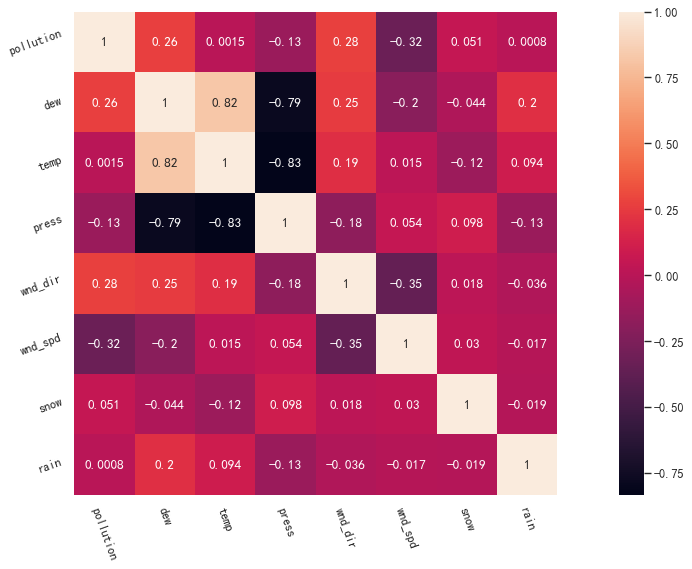

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8), dpi=80)
hitmapTemp = df[list(df.columns)]
hitmapData = hitmapTemp.corr(method='spearman') # method：可选值为{‘pearson’, ‘kendall’, ‘spearman’}
sns.heatmap(hitmapData, vmax=1, square=True, annot=True)
# plt.savefig('./figs/Correlation-Matrix.png')
plt.xticks(rotation=-70)
plt.yticks(rotation=20)
plt.show()

In [46]:
from sklearn.preprocessing import MinMaxScaler
# 确保所有数据是浮点数类型
values = df.values
values = values.astype('float32')  

# # 对特征标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# 分离出特征和标签
data = scaled
label = scaled[:, 0]

In [47]:
def generate_pair(x, ts):
    length = len(x)
    start, end = 0, length - ts
    data = []
    label = []
    for i in range(end):
        data.append(x[i: i+ts, :])
        label.append(x[i+ts, :])
    return np.array(data, dtype=np.float64), np.array(label, dtype=np.float64)

In [48]:
window_size = 72
data1, label1 = generate_pair(data, ts=window_size)

In [49]:
# 划分数据集
train_test_split = int(0.7 * len(label1))
train_X = data1[0: train_test_split]
train_y = label1[0: train_test_split]
test_X = data1
test_y = label1

In [50]:
print(len(df))
print(test_y.shape)

43800
(43728, 8)


In [51]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, features, targets): #HDKIM 100
        super(MyDataset, self).__init__()
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index].astype('float32'), self.targets[index].astype('float32')

batch_size = 64
train_dataset = MyDataset(train_X, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MyDataset(test_X, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [52]:
from model import TF
from pytorch_ranger import Ranger

model = TF(in_features=8)

optimizer = Ranger(model.parameters(), lr=8e-4)
criterion = nn.MSELoss(reduction='mean')

epochs = 10
cos_epoch=int(epochs*0.75)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, (epochs-cos_epoch)*len(train_dataloader))
steps_per_epoch=len(train_dataloader)

In [53]:
import time

device = 'cpu'

Loss = []
train_Loss = []
test_Loss = []

for epoch in range(epochs):
    print(epoch)
    model.train()
    train_loss = 0
    t = time.time()
    for idx, inputs in enumerate(train_dataloader):
        feature, target = inputs
        # print(feature.shape)
        feature = feature.to(device)                      
        target = target.to(device)

        optimizer.zero_grad()
        output = model(feature)
        # print('output shape', output.shape)

        loss = criterion(output.reshape(-1, 8), target)       
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_Loss.append(loss.item())
        # print('Epoch:{}, {}'.format(epoch+1, loss.item()))
        if epoch > cos_epoch:
            scheduler.step()

    model.eval()
    Loss.append(train_loss)

    val_loss = 0
    t = time.time()
    for idx, inputs in enumerate(test_dataloader):
        feature, target = inputs
        features = feature.to(device)
        targets = target.to(device)

        with torch.no_grad():
            output = model(features)
            loss = criterion(output.reshape(-1, 8), target)
            val_loss += loss.item()
            
    torch.save(model.state_dict(), 'model{}.pth'.format(val_loss))
    test_Loss.append(val_loss)
    print('Epoch:{}, train_loss is {}'.format(epoch+1, train_loss))
    print('Epoch:{}, val_loss is {}'.format(epoch+1, val_loss))

0
Epoch:1, train_loss is 112.21513432264328
Epoch:1, val_loss is 130.81708072125912
1
Epoch:2, train_loss is 86.99112583696842
Epoch:2, val_loss is 124.46054027974606
2
Epoch:3, train_loss is 85.55820488929749
Epoch:3, val_loss is 123.12364625930786
3
Epoch:4, train_loss is 84.98307113349438
Epoch:4, val_loss is 122.54157611727715
4
Epoch:5, train_loss is 84.52152732014656
Epoch:5, val_loss is 122.32330952584743
5
Epoch:6, train_loss is 84.36591497063637
Epoch:6, val_loss is 122.21392279863358
6
Epoch:7, train_loss is 84.24538686871529
Epoch:7, val_loss is 121.97590191662312
7
Epoch:8, train_loss is 84.00956930220127
Epoch:8, val_loss is 121.76913161575794
8
Epoch:9, train_loss is 84.06722001731396
Epoch:9, val_loss is 121.76828519999981
9
Epoch:10, train_loss is 83.96107643842697
Epoch:10, val_loss is 121.87800407409668


In [54]:
# state_dict = torch.load('model_state_dict.pth')
# model.load_state_dict(state_dict)

input_X = torch.from_numpy(test_X).to(torch.float32)
yhat = model(input_X).detach().numpy().reshape(-1, 8)

30559 30659


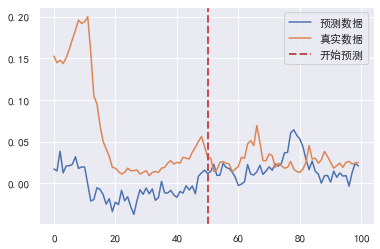

In [55]:
# 绘图
lb = train_test_split-50
ub = train_test_split+50
print(lb, ub)
plt.plot(range(len(yhat[lb: ub, 0])), yhat[lb: ub, 0])
plt.plot(range(len(test_y[lb: ub, 0])), test_y[lb: ub, 0])
plt.axvline(x=50, c="r", ls="--", lw=2)
plt.legend(['预测数据', '真实数据', '开始预测'])
plt.show()

In [61]:
target = 12
lst = []
for i in range(target):

    input_x = data[len(data)-window_size:len(data), :]
    input_x = np.expand_dims(input_x, axis=0)
    input_x = torch.from_numpy(input_x)
    y_pred = model(input_x).detach().numpy().reshape(-1, 8)
    data = np.vstack((data, y_pred))
    lst.append(y_pred)

(43800, 8)
(43801, 8)
(43802, 8)
(43803, 8)
(43804, 8)
(43805, 8)
(43806, 8)
(43807, 8)
(43808, 8)
(43809, 8)
(43810, 8)
(43811, 8)


In [62]:
result = np.array(lst).squeeze(1)
result = scaler.inverse_transform(result)
result[:,0]

array([  0.48991174, -44.808643  ,   3.9609594 , -38.45181   ,
        39.6474    ,  48.062077  ,  10.124556  ,   8.031118  ,
       -18.03767   , -16.875025  ,  62.737415  ,  -7.406627  ],
      dtype=float32)

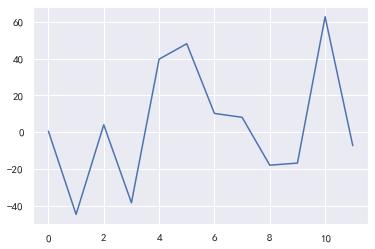

In [63]:
plt.plot(result[:,0])
plt.show()